In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix, roc_auc_score)
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 6.01 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.44 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 786 µs


### Database ERD

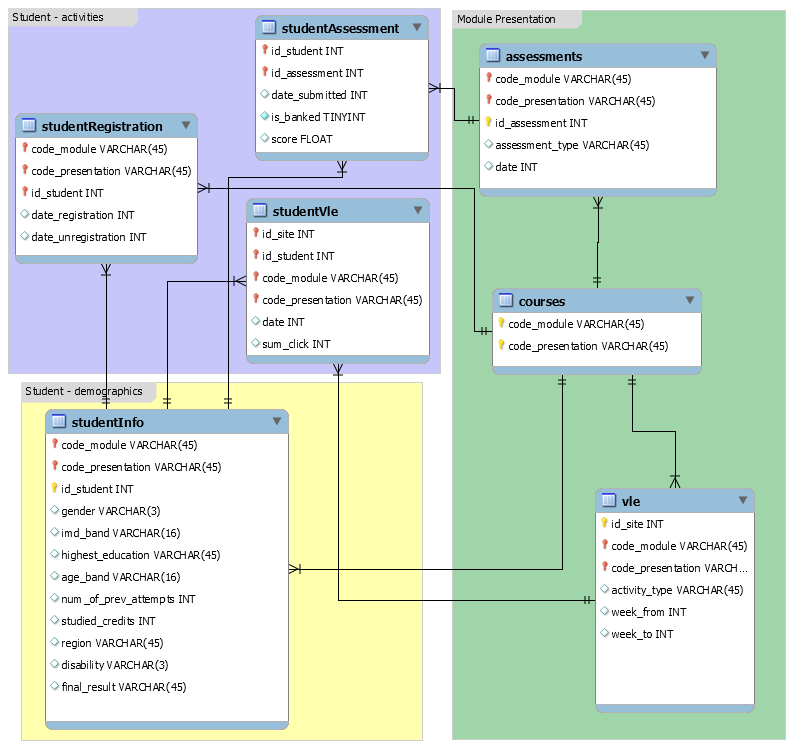

time: 3.64 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.09 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.06 ms


## Half Term Data

In [9]:
# creating dataframe
df = db.data_prep(120)

# cleaning data frame
drops = ['row_id', 'studied_credits',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date']

df = db.pipe_cleaner_wa(df, drops).reset_index(drop=True)

In [12]:
# saving columns as series for use in error data frame
final_result = df['final_result'].copy()
code_module = df['code_module'].copy()
code_presentation = df['code_presentation'].copy()

In [13]:
# dropping columns
df = df.drop(['final_result', 'code_presentation',
              'code_module', 'id_student'], axis=1)

time: 4.9 ms


## Creating Holdout Data

In [15]:
# splitting data & target
X, y = f.X_y(df)

time: 3.09 ms


In [16]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 11.1 ms


## Creating Training Data

In [17]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.22 ms


## Loading Model

In [18]:
model = f.load_model('xgb_f1_tuned')

time: 49.9 ms


## Error Data Frame

In [37]:
y_pred = model.predict(X_test)
errors = X_test.copy()
errors['result'] = y_test
errors['prediction'] = y_pred
errors['label'] = final_result
errors['code_module'] = code_module
errors['code_presentation'] = code_presentation

time: 88.2 ms


In [38]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3911 entries, 10369 to 1645
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   gender                3911 non-null   object  
 1   region                3911 non-null   object  
 2   highest_education     3911 non-null   object  
 3   imd_band              3911 non-null   object  
 4   age_band              3911 non-null   object  
 5   num_of_prev_attempts  3911 non-null   float64 
 6   disability            3911 non-null   object  
 7   weighted_ave          3911 non-null   float64 
 8   mean_score            3911 non-null   float64 
 9   median_score          3911 non-null   float64 
 10  sum_activity          3911 non-null   float64 
 11  course_load           3911 non-null   category
 12  result                3911 non-null   float64 
 13  prediction            3911 non-null   float64 
 14  label                 3911 non-null   object  
 15  

## Outcome Error Rates

In [39]:
label_counts = errors.label.value_counts()
label_errors = errors[errors['result'] != errors['prediction']]['label'].value_counts()
error_rates = label_errors/label_counts
total_errors = label_errors.sum()
share_total_errors = label_errors/total_errors

time: 7.05 ms


In [40]:
error_rates

Distinction    0.037113
Fail           0.305835
Pass           0.221264
Withdrawn      0.430233
Name: label, dtype: float64

time: 2.83 ms


In [41]:
share_total_errors

Pass           0.495708
Fail           0.326180
Withdrawn      0.158798
Distinction    0.019313
Name: label, dtype: float64

time: 3.12 ms


In [42]:
normalized_counts = errors.label.value_counts(normalize=True)
normalized_counts

Pass           0.533879
Fail           0.254155
Distinction    0.124009
Withdrawn      0.087957
Name: label, dtype: float64

time: 5.03 ms


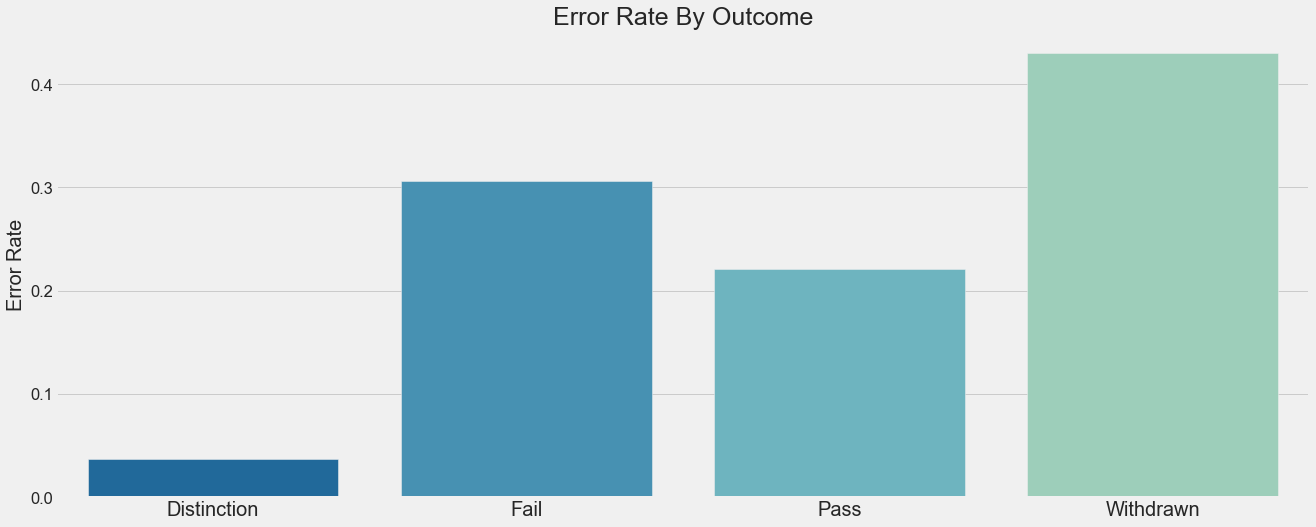

time: 117 ms


In [43]:
v.error_rate(errors)

## Numerical Feature Error Analysis

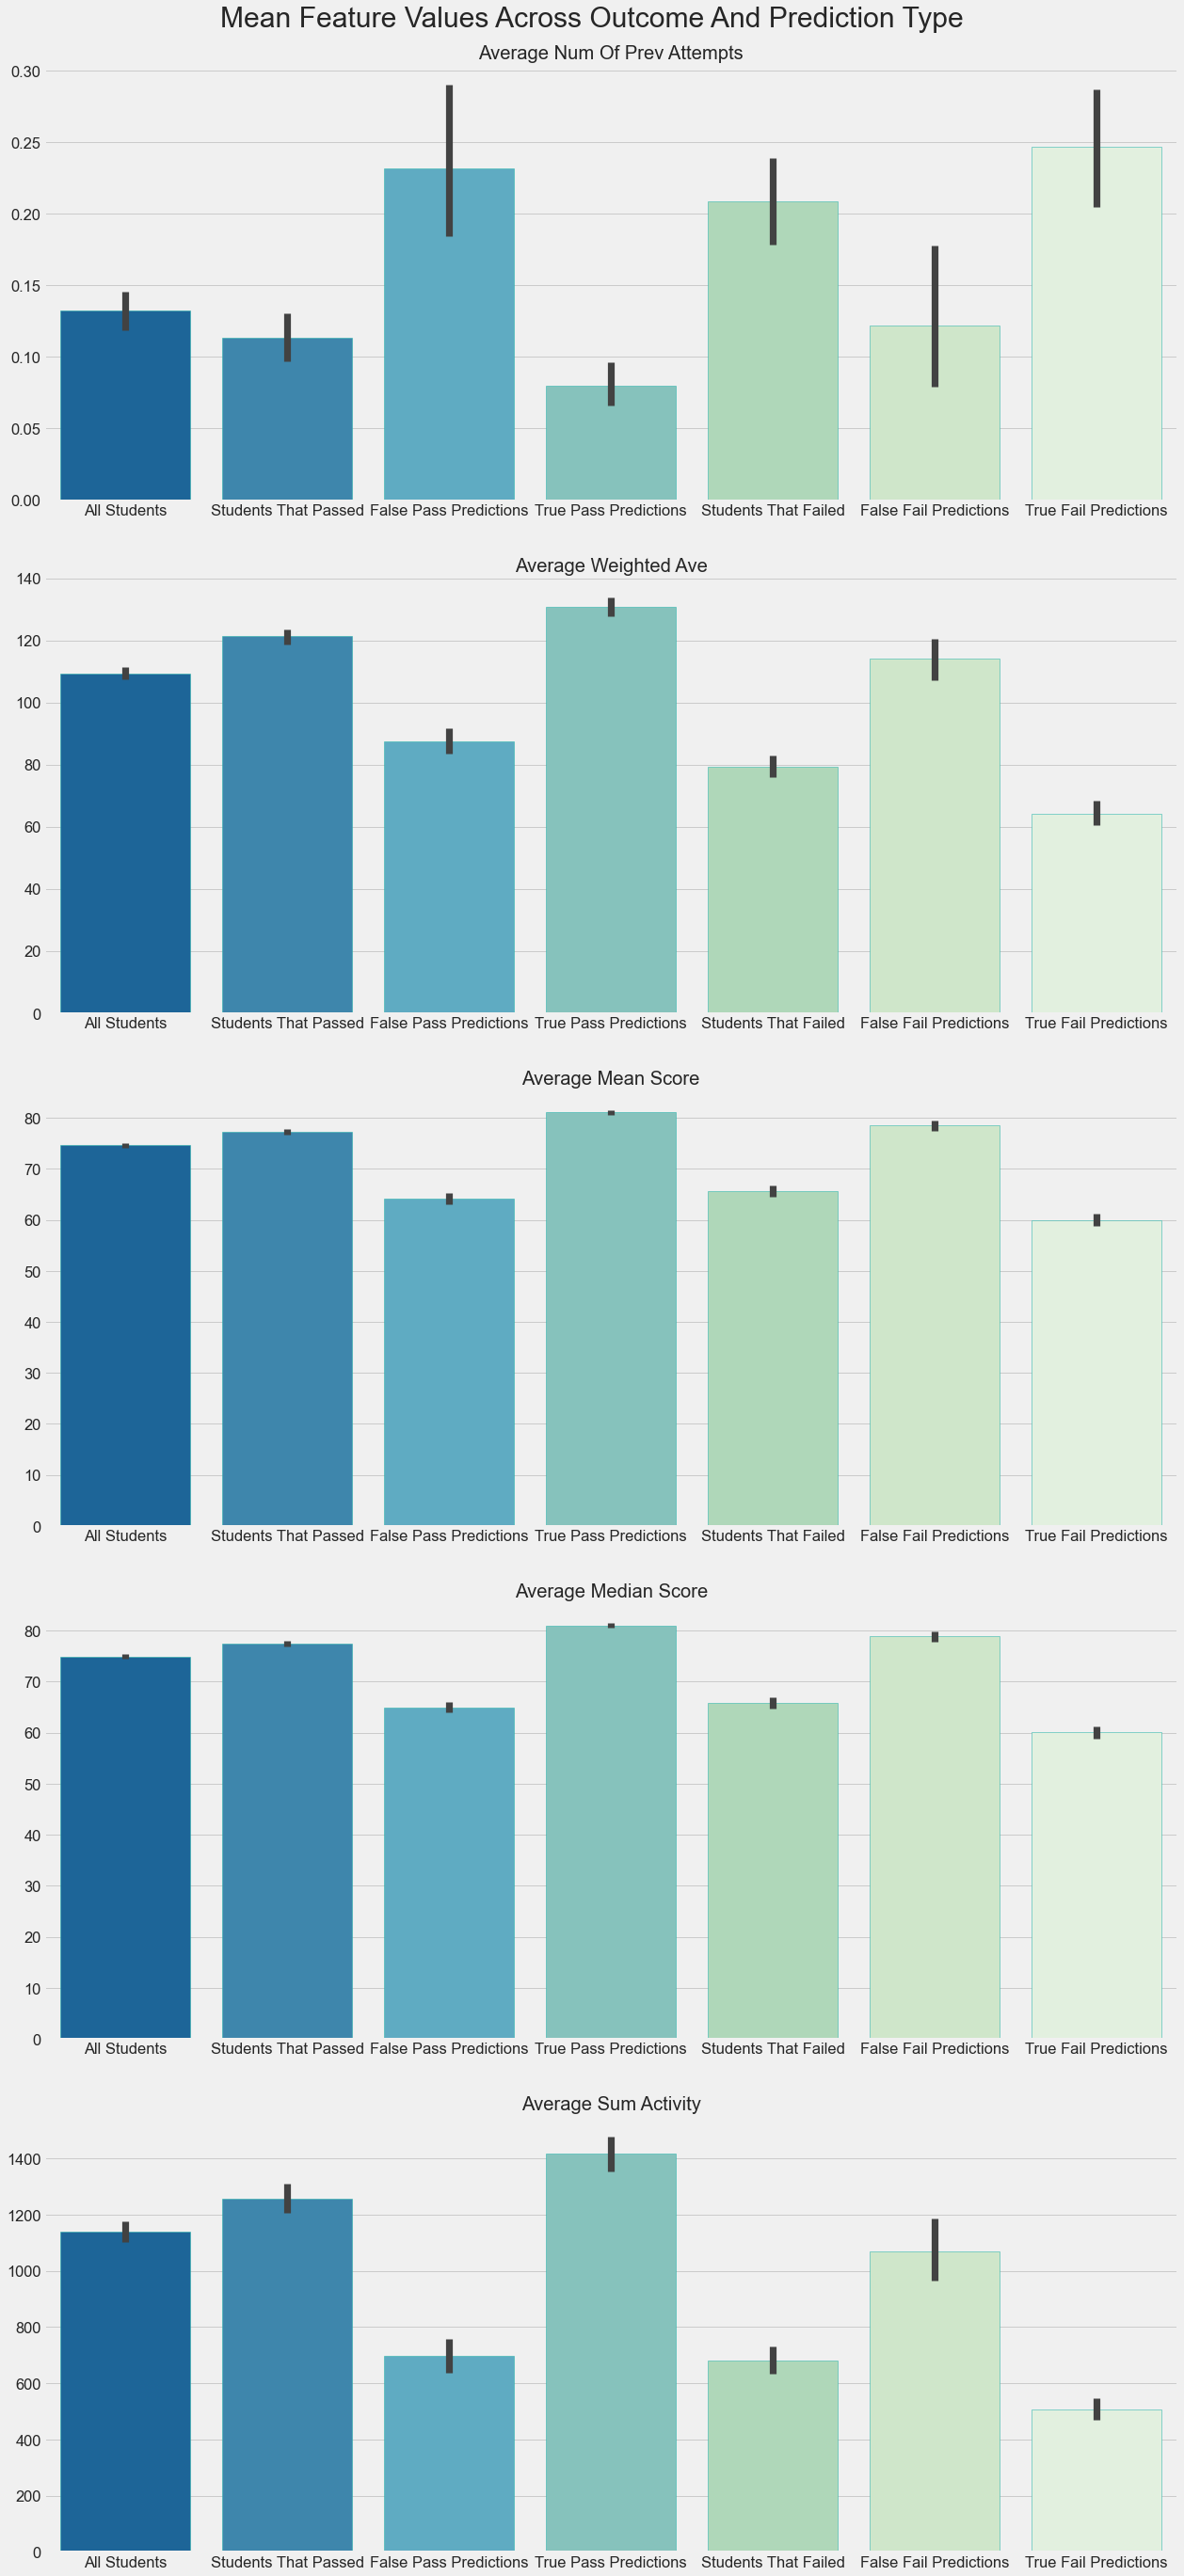

time: 1.72 s


In [44]:
num_cols = ['num_of_prev_attempts','weighted_ave','mean_score',
            'median_score','sum_activity']
v.numerical_errors(errors, num_cols)

## Categorical Feature Error Analysis

In [45]:
# dropping numerical features
drops = ['num_of_prev_attempts','weighted_ave', 'mean_score',
            'median_score', 'sum_activity']
cat_errors = errors.drop(columns=drops)
# creating true predictions column
cat_errors['true_prediction'] = np.where(errors['prediction'] == errors['result'], True, False)
# dropping extraneous columns
cat_errors = cat_errors.drop(columns = ['result', 'prediction', 'label'])

time: 4.6 ms


In [46]:
# checking work
cat_errors.head()

,gender,region,highest_education,imd_band,age_band,disability,course_load,code_module,code_presentation,true_prediction
10369,Male,Scotland,A Level or Equivalent,90-100%,0-35,No,Heavy,DDD,2014B,False
8133,Male,North Western Region,A Level or Equivalent,80-90%,0-35,No,Light,CCC,2014J,False
10236,Male,South Region,HE Qualification,90-100%,0-35,No,Medium,DDD,2013J,True
12232,Male,London Region,A Level or Equivalent,20-30%,0-35,No,Medium,EEE,2013J,False
14979,Female,Scotland,Lower Than A Level,60-70%,35-55,No,Heavy,FFF,2013B,True


time: 9.52 ms


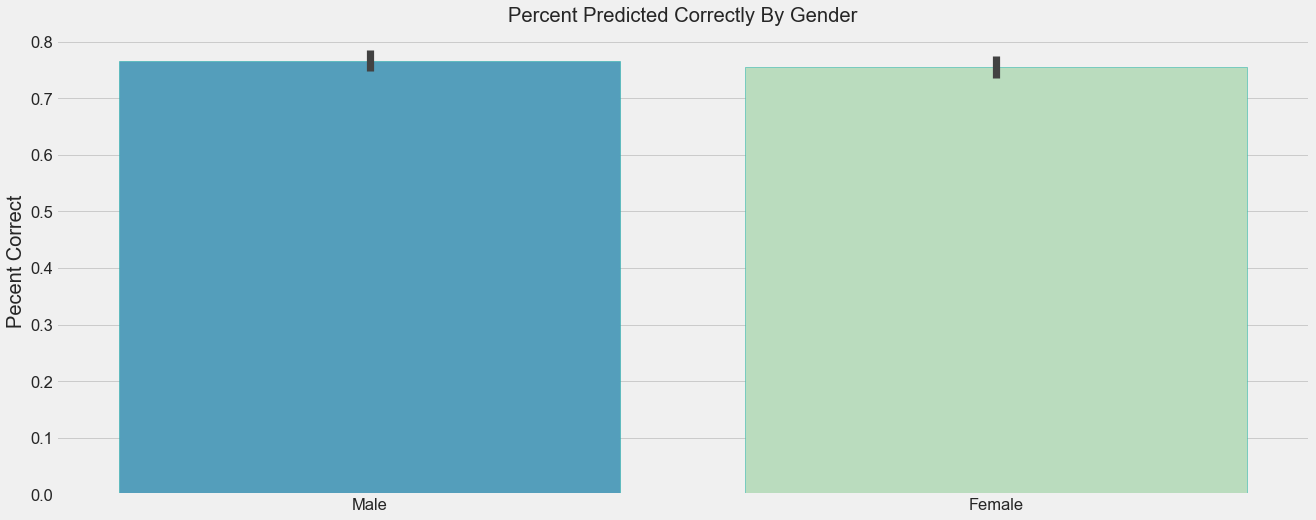

time: 184 ms


In [47]:
v.categorical_errors(cat_errors, 'gender')

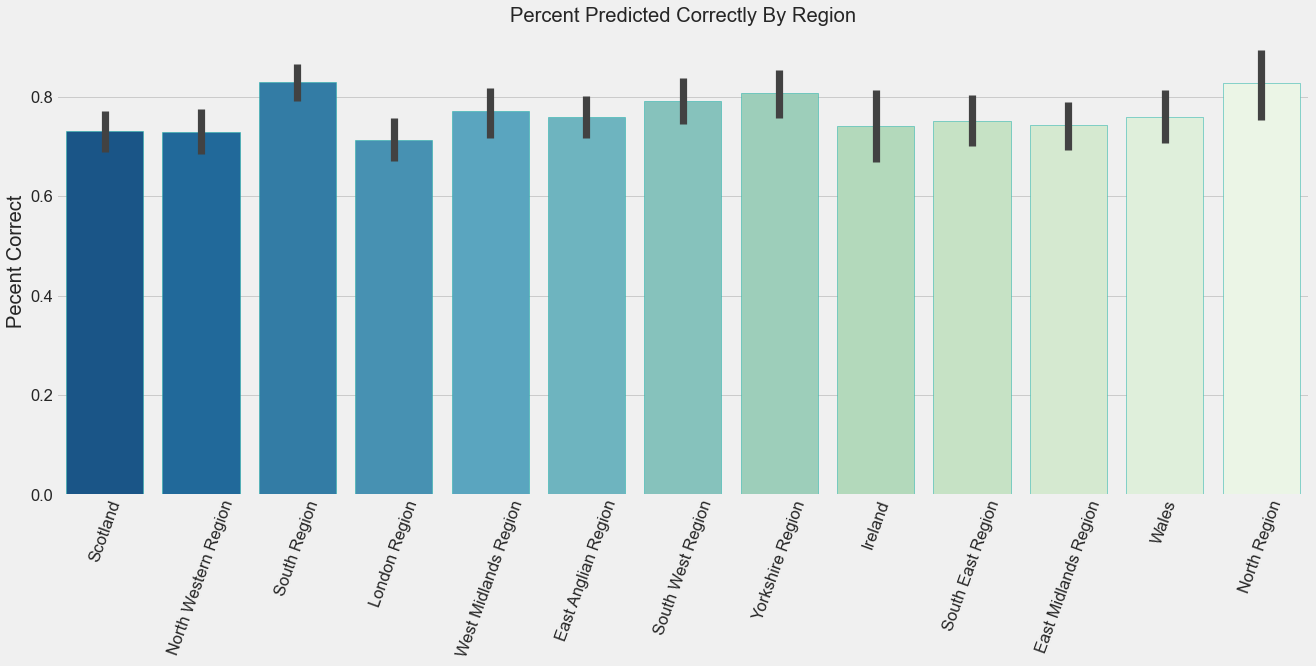

time: 428 ms


In [48]:
v.categorical_errors(cat_errors, 'region', 70)

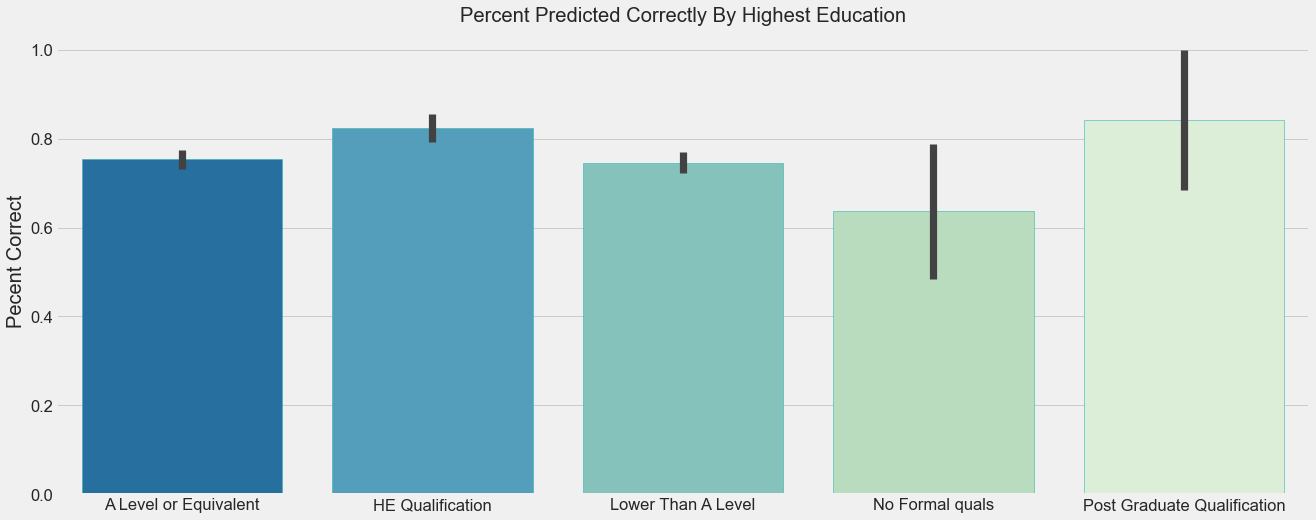

time: 241 ms


In [49]:
v.categorical_errors(cat_errors, 'highest_education')

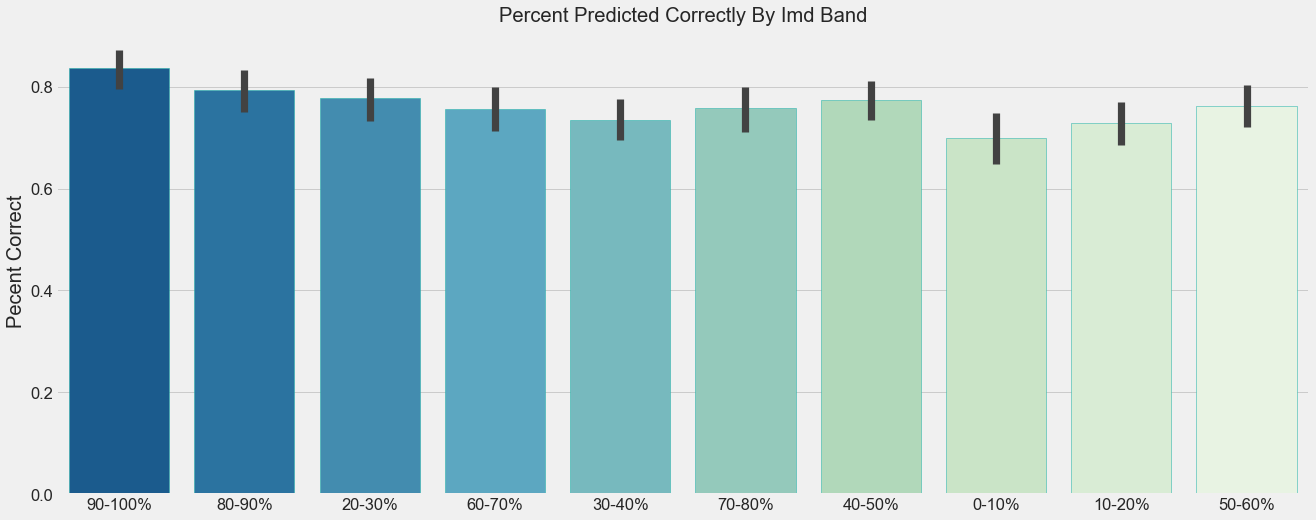

time: 332 ms


In [50]:
v.categorical_errors(cat_errors, 'imd_band')

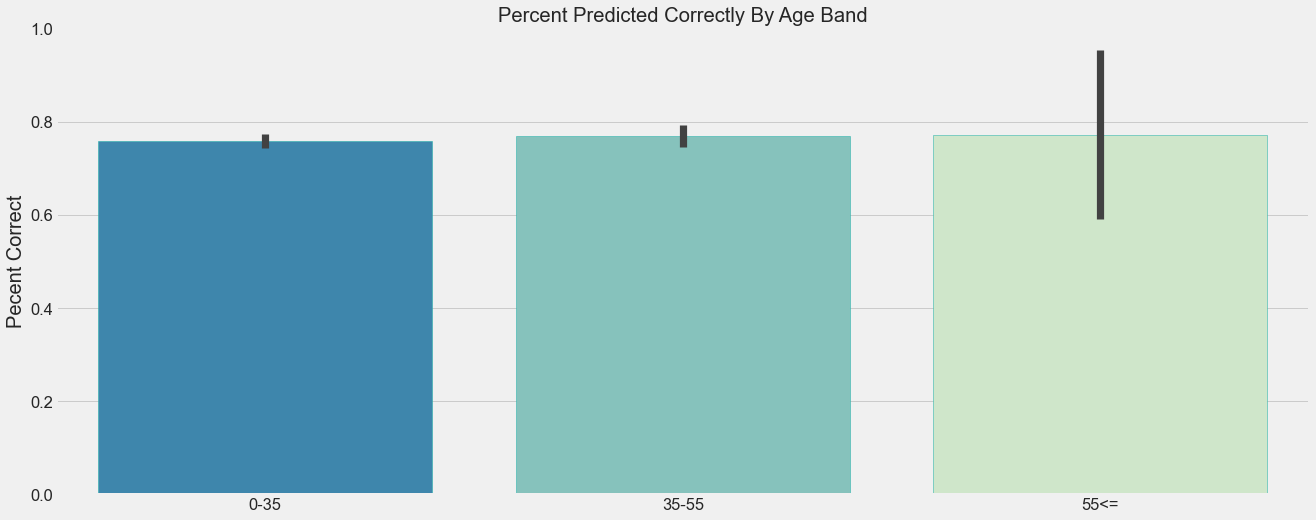

time: 201 ms


In [51]:
v.categorical_errors(cat_errors, 'age_band')

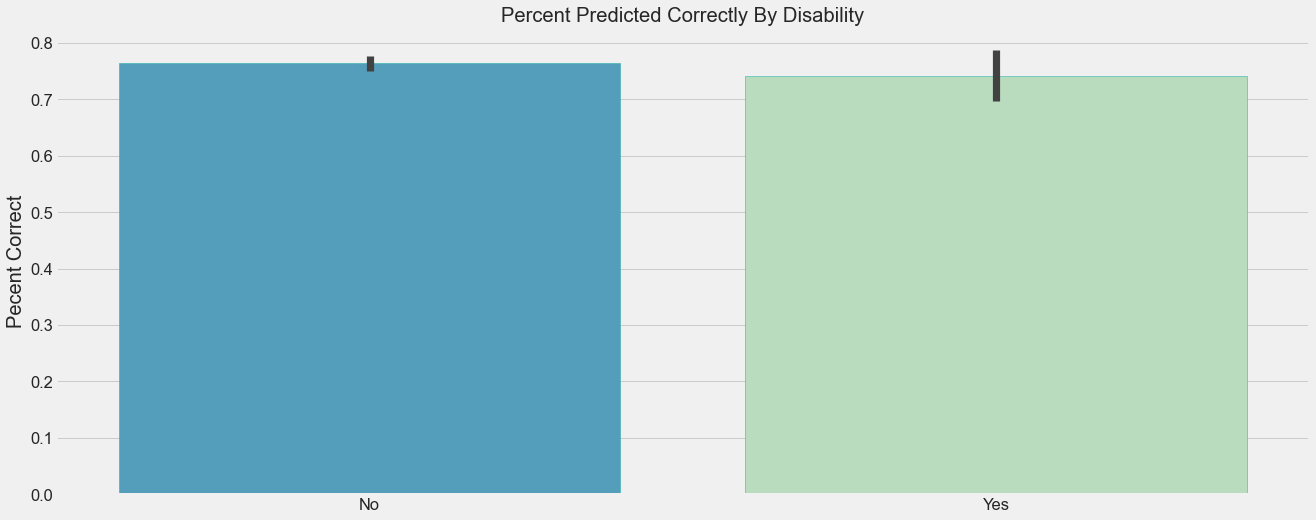

time: 172 ms


In [52]:
v.categorical_errors(cat_errors, 'disability')

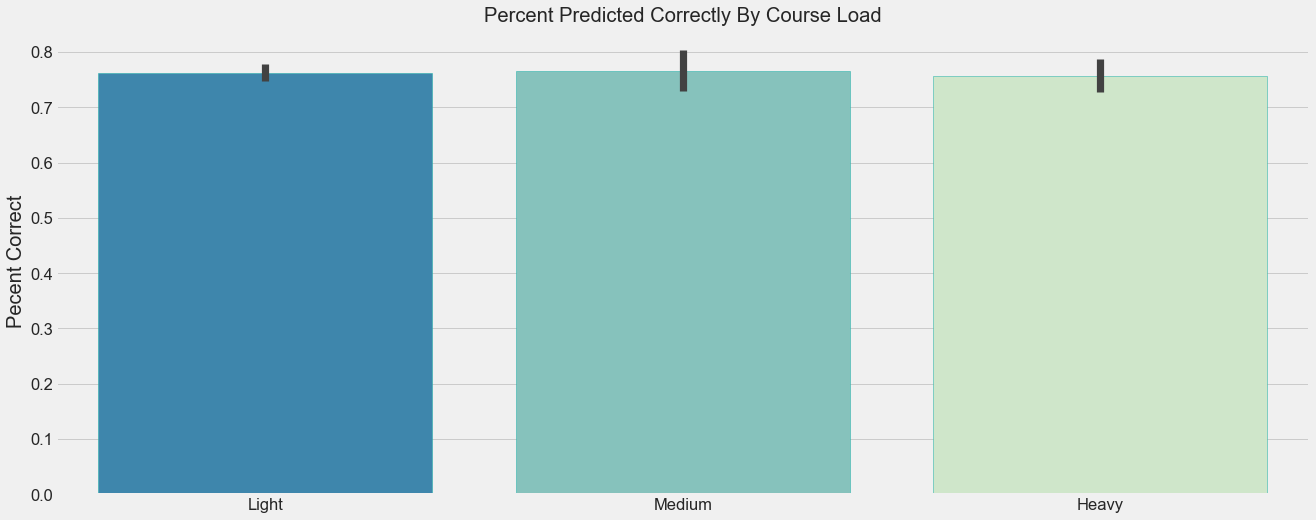

time: 202 ms


In [53]:
v.categorical_errors(cat_errors, 'course_load')

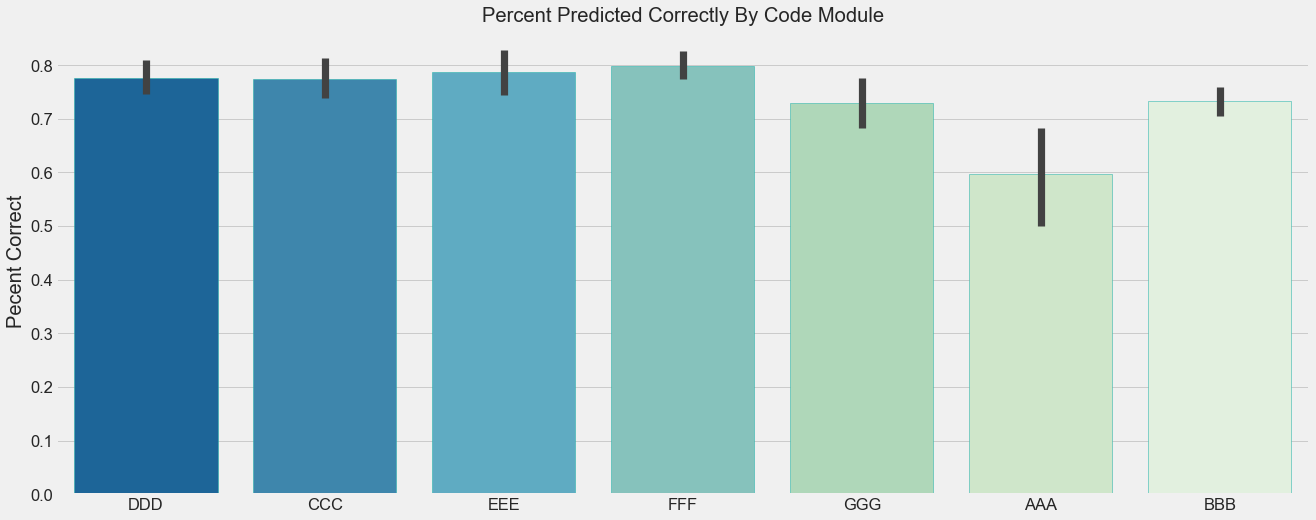

time: 283 ms


In [54]:
v.categorical_errors(cat_errors, 'code_module')

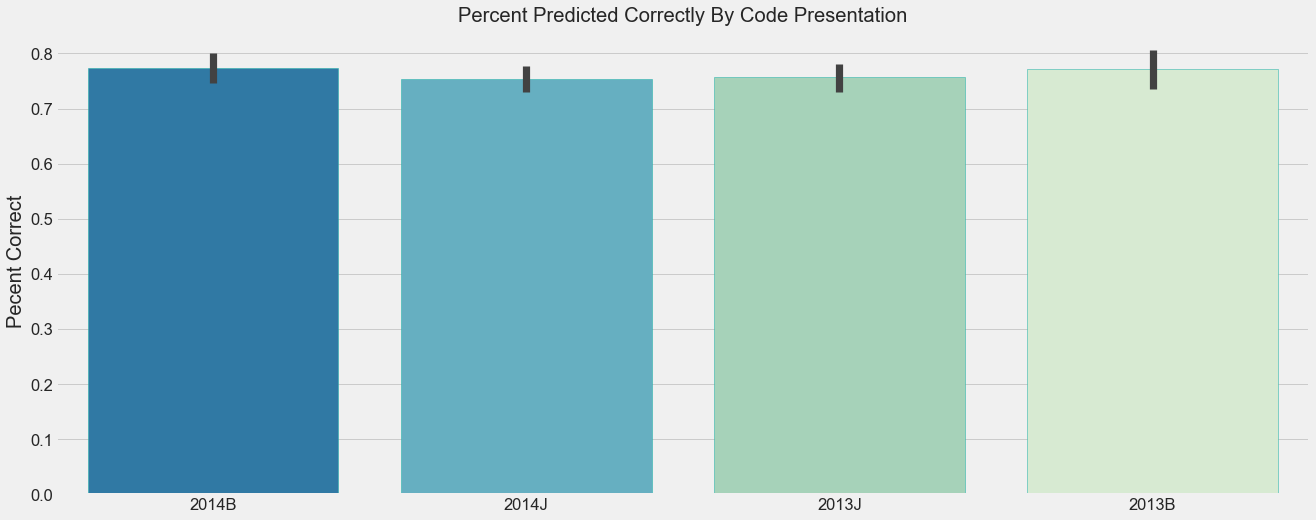

time: 224 ms


In [55]:
v.categorical_errors(cat_errors, 'code_presentation')